# Aerial images road segmentation with a Unet
by Braz Lucas, Durand Pierre-Alain and Nicolle Clement


### Importing librairies

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm, trange
import glob
import os
import sys
from PIL import Image
from scipy import ndimage

### Verify if a GPU is usable

In [2]:
# If a GPU is available
if not torch.cuda.is_available():
  raise Exception("Things will go much quicker if you enable a GPU in Colab under 'Runtime / Change Runtime Type'")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visualisation function

In [3]:
def imshow(img, ax=None):
    """
    displays an image with matplotlib directly from Pytorch format : Channel*H*W
    with figsize 7inch² and without axes
    """
    if torch.is_tensor(img):
        img = img.detach().cpu().numpy()
    
    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(7,7))
    if len(img.shape) == 3:
        fig = ax.imshow(np.moveaxis(img, 0, -1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    else:
        fig = ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def imshow_overlay_test(img_to_show):
    """
    Show chosen images from the test dataset with the model prediction overlayed on it
    """
    img_to_show = (img_to_show,) if isinstance(img_to_show,int) else img_to_show
    fig, ax = plt.subplots(len(img_to_show)//2+len(img_to_show)%2,2,figsize=(15,8*(len(img_to_show)//2+len(img_to_show)%2)))
    ax = ax.flatten()
    for idx, img in enumerate(img_to_show):
        img_real = dataset_test[img].detach().cpu().numpy()
        img_real = np.moveaxis(img_real, 0, -1)
        img_to_print = make_img_overlay(img_real,imgs[img])
        fig = ax[idx].imshow(img_to_print)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    if len(img_to_show)%2 != 0:
        ax[len(img_to_show)].get_xaxis().set_visible(False)
        ax[len(img_to_show)].get_yaxis().set_visible(False)

def imshow_overlay_validation(img_to_show):
    """
    Show chosen images from validation dataset with the ground truth overlayed on it on right
    Show chosen images from validation dataset with the model prediction overlayed on it on right
    """
    img_to_show = (img_to_show,) if isinstance(img_to_show,int) else img_to_show
    fig, ax = plt.subplots(len(img_to_show),2,figsize=(15,8*len(img_to_show)))
    ax = ax.flatten()
    for idx, img in enumerate(img_to_show):
        img_real = dataset_valid[img][0][0].detach().cpu().numpy()
        img_real = np.moveaxis(img_real, 0, -1)
        img_target = dataset_valid[img][1][0].detach().cpu().numpy()
        img_to_print = make_img_overlay(img_real,img_target)
        fig = ax[2*idx].imshow(img_to_print)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        ax[2*idx].set_title(f"Image {img} : target")

        img_pred = model(dataset_valid[img][0].to(device))[0].argmax(0).detach().cpu().numpy()
        img_to_print = make_img_overlay(img_real,img_pred)
        fig = ax[2*idx+1].imshow(img_to_print)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        ax[2*idx+1].set_title(f"Image {img} : prediction")

In [4]:
def rotate45(img):
    """
    input: image (400*400*3)
    output: 45° rotated image (272*272*3)

    Rotate an image (400*400) of 45° and crop in order to keep the zoom level of the original image
    but without the border due to rotation
    """
    img = ndimage.rotate((img*255).astype(np.uint8),45).astype(np.float32)/255
    cropx = 272
    cropy = 272
    if img.ndim == 3:
        y,x,_ = img.shape
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)
        img = img[starty:starty+cropy,startx:startx+cropx,:]
    else:
        y,x = img.shape
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)
        img = img[starty:starty+cropy,startx:startx+cropx]
    
    return img

### Functions to create submission

In [5]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(nb, imgs):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = imgs[nb]
    img_number = nb+1
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, imgs):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(len(imgs)):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(i,imgs))

### Import and pre processing of data

In [6]:
dataset_train = [np.moveaxis(mpimg.imread(f"training/images/satImage_{i:03}.png"), -1, 0) for i in range(1,101)]
dataset_train += [np.moveaxis(np.transpose(mpimg.imread(f"training/images/satImage_{i:03}.png"),(1,0,2)), -1, 0) for i in range(1,101)]
dataset_train += [np.moveaxis(mpimg.imread(f"training/images/satImage_{i:03}.png")[::-1,::  ,:], -1, 0) for i in range(1,101)]
dataset_train += [np.moveaxis(mpimg.imread(f"training/images/satImage_{i:03}.png")[::  ,::-1,:], -1, 0) for i in range(1,101)]
dataset_train += [np.moveaxis(mpimg.imread(f"training/images/satImage_{i:03}.png")[::-1,::-1,:], -1, 0) for i in range(1,101)]
dataset_train += [np.moveaxis(rotate45(mpimg.imread(f"training/images/satImage_{i:03}.png")), -1, 0) for i in range(1,101)]
dataset_train += [np.moveaxis(np.transpose(rotate45(mpimg.imread(f"training/images/satImage_{i:03}.png")),(1,0,2)), -1, 0) for i in range(1,101)]
dataset_train += [np.moveaxis(np.transpose(rotate45(mpimg.imread(f"training/images/satImage_{i:03}.png")[::-1,::  ,:]),(1,0,2)), -1, 0) for i in range(1,101)]


labels_train = [mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8) for i in range(1,101)]
labels_train += [np.transpose(mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8),(1,0)) for i in range(1,101)]
labels_train += [mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8)[::-1,::  ] for i in range(1,101)]
labels_train += [mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8)[::  ,::-1] for i in range(1,101)]
labels_train += [mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8)[::-1,::-1] for i in range(1,101)]
labels_train += [rotate45(mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8)) for i in range(1,101)]
labels_train += [np.transpose(rotate45(mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8)),(1,0)) for i in range(1,101)]
labels_train += [np.transpose(rotate45(mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8)[::-1,::  ]),(1,0)) for i in range(1,101)]

dataset_test = np.array([mpimg.imread(f"test_set_images/test_{i}/test_{i}.png") for i in range(1,51)])
dataset_test = np.moveaxis(dataset_test, -1, 1)
dataset_test = torch.from_numpy(dataset_test.copy())

In [7]:
print(f"len(dataset_train) : {len(dataset_train)}")
print(f"len(labels_train) : {len(labels_train)}")
print(f"dataset_train[0].shape : {dataset_train[0].shape}")
print(f"dataset_train[-1].shape : {dataset_train[-1].shape}")
print(f"labels[0].shape : {labels_train[0].shape}")
print(f"labels[-1].shape : {labels_train[-1].shape}")
print(f"dataset_test.shape : {dataset_test.shape}")

len(dataset_train) : 800
len(labels_train) : 800
dataset_train[0].shape : (3, 400, 400)
dataset_train[-1].shape : (3, 272, 272)
labels[0].shape : (400, 400)
labels[-1].shape : (272, 272)
dataset_test.shape : torch.Size([50, 3, 608, 608])


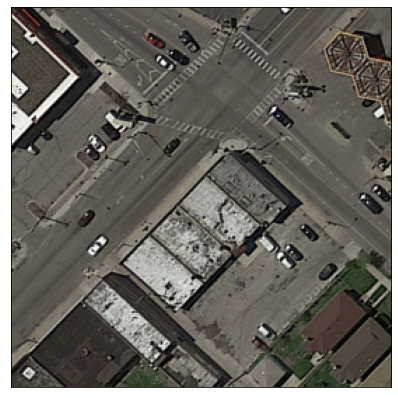

In [8]:
imshow(dataset_train[-1])

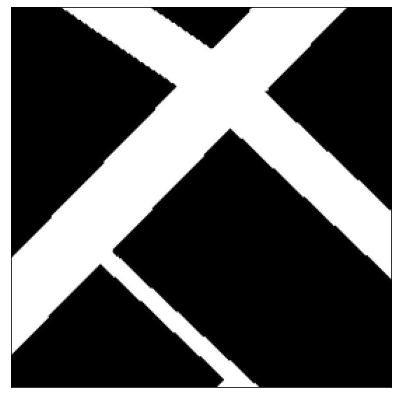

In [9]:
imshow(labels_train[-1]);

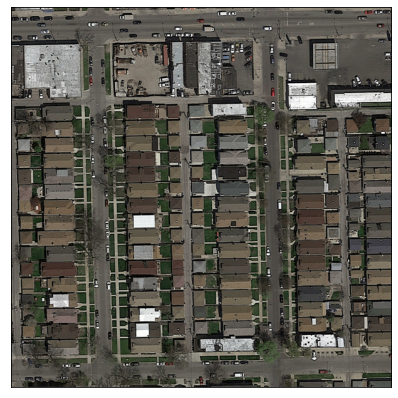

In [10]:
imshow(dataset_test[0]);

In [11]:
random_seed = 0

train_size = 0.95

inputs_train, inputs_valid = train_test_split(
    dataset_train,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    labels_train,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

inputs_train = [torch.from_numpy(img.copy()) for img in inputs_train]
inputs_valid = [torch.from_numpy(img.copy()) for img in inputs_valid]
targets_train = [torch.from_numpy(img.copy()).type(torch.LongTensor) for img in targets_train]
targets_valid = [torch.from_numpy(img.copy()).type(torch.LongTensor) for img in targets_valid]

In [12]:
print(f"inputs_train dtype : {inputs_train[0].dtype}")
print(f"inputs_valid dtype : {inputs_valid[0].dtype}")
print(f"targets_train dtype : {targets_train[0].dtype}")
print(f"targets_valid dtype : {targets_valid[0].dtype}")
print(f"dataset_test.dtype : {dataset_test.dtype}")

inputs_train dtype : torch.float32
inputs_valid dtype : torch.float32
targets_train dtype : torch.int64
targets_valid dtype : torch.int64
dataset_test.dtype : torch.float32


In [13]:
# 1 image per batch actually
dataset_training = [[inputs_train[i][None], targets_train[i][None]] for i in range(len(inputs_train))]
dataset_valid = [[inputs_valid[i][None], targets_valid[i][None]] for i in range(len(inputs_valid))]

### Creation of the MODEL UNET

In [14]:
class Unet_Vanilla(nn.Module):
    """
    Vanilla Unet as define in the paper : https://arxiv.org/pdf/1505.04597.pdf
    """
    def __init__(self):
        super().__init__()
        self.downblock1 = nn.Sequential(
            # nn.Dropout2d(0.2),
            nn.Conv2d(3, 64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.downblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),          
            nn.Conv2d(128, 256, kernel_size=3),
            # nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            # nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.downblock4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3),
            # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3),
            # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.middleU = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(512, 1024, kernel_size=3),
            # nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3),
            # nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )

        self.upblock1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3),
            # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3),
            # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        )

        self.upblock2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3),
            # nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            # nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.upblock3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        )

        self.upblock4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1)
        )
    

    def forward(self, x):
        x1 = self.downblock1(x)

        x2 = self.downblock2(x1)

        x3 = self.downblock3(x2)

        x4 = self.downblock4(x3)

        xmiddle = self.middleU(x4)

        x4cut = x4[:,:,4:-4,4:-4]
        xup0_1 = torch.cat((x4cut,xmiddle), dim=1)
        xup1 = self.upblock1(xup0_1)

        x3cut = x3[:,:,16:-17,16:-17]
        xup1_2 = torch.cat((x3cut,xup1), dim=1)
        xup2 = self.upblock2(xup1_2)

        x2cut = x2[:,:,41:-41,41:-41]
        xup2_3 = torch.cat((x2cut,xup2), dim=1)
        xup3 = self.upblock3(xup2_3)
        
        x1cut = x1[:,:,90:-90,90:-90]
        xup3_4 = torch.cat((x1cut,xup3), dim=1)
        xup4 = self.upblock4(xup3_4)

        adaptsize = nn.Upsample(x.shape[2]).to(device)

        xfinal = adaptsize(xup4)

        return xfinal

In [15]:
class Unet(nn.Module):
    """
    Our modified Unet :
    Use of padding to keep size of input in output easily.
    Use of batchnorm2d after Conv2d
    """
    def __init__(self):
        super().__init__()

        self.downblock1 = nn.Sequential(
            # nn.Dropout2d(0.2),
            nn.Conv2d(3, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.downblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),          
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.downblock4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.middleU = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(512, 1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )

        self.upblock1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        )

        self.upblock2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.upblock3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        )

        self.upblock4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1)
        )
    

    def forward(self, x):
        x1 = self.downblock1(x)

        x2 = self.downblock2(x1)

        x3 = self.downblock3(x2)

        x4 = self.downblock4(x3)


        xmiddle = self.middleU(x4)


        xup0_1 = torch.cat((x4,xmiddle), dim=1)
        xup1 = self.upblock1(xup0_1)

        xup1_2 = torch.cat((x3,xup1), dim=1)
        xup2 = self.upblock2(xup1_2)

        xup2_3 = torch.cat((x2,xup2), dim=1)
        xup3 = self.upblock3(xup2_3)

        xup3_4 = torch.cat((x1,xup3), dim=1)
        xup4 = self.upblock4(xup3_4)

        return xup4

### Creation of the criterion and functions for training and validation

In [16]:
def train_epoch(data_loader, model, optimiser, device, criterion):

  # set model to training mode. This is important because some layers behave differently during training and testing
  model.train(True)
  model.to(device) # (if not already do)

  # stats
  loss_total = 0.0
  f1_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target) in enumerate(data_loader):

    # put data and target onto correct device (if not already do)
    data, target = data.to(device), target.to(device)

    # reset gradients
    optimiser.zero_grad()

    # forward pass
    pred = model(data)

    # loss
    loss = criterion(pred, target)

    # backward pass
    loss.backward()

    # parameter update
    optimiser.step()

    # stats update
    loss_total += loss.item()
    f1_total += f1_score(target.detach().cpu().numpy().flatten(), pred.argmax(1).detach().cpu().numpy().flatten(),zero_division=0)
    oa_total += torch.mean((pred.argmax(1) == target).float()).item()

    # format progress bar
    pBar.set_description('Loss: {:.2f}, F1: {:.2f}, OA: {:.2f}'.format(
      loss_total/(idx+1),
      100 * f1_total/(idx+1),
      100 * oa_total/(idx+1)
    ))
    pBar.update(1)
  
  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  f1_total /= len(data_loader)
  oa_total /= len(data_loader)

  return model, loss_total, f1_total, oa_total

In [17]:
def validate_epoch(data_loader, model, device, criterion):

  # set model to evaluation mode
  model.train(False)
  model.to(device) # (if not already do)

  # stats
  loss_total = 0.0
  f1_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target) in enumerate(data_loader):
    with torch.no_grad():

      # put data and target onto correct device (if not already do)
      data, target = data.to(device), target.to(device)

      # forward pass
      pred = model(data)

      # loss
      loss = criterion(pred, target)

      # stats update
      loss_total += loss.item()
      f1_total += f1_score(target.detach().cpu().numpy().flatten(), pred.argmax(1).detach().cpu().numpy().flatten(),zero_division=0)
      oa_total += torch.mean((pred.argmax(1) == target).float()).item()

      # format progress bar
      pBar.set_description('Loss: {:.2f}, F1: {:.2f}, OA: {:.2f}'.format(
      loss_total/(idx+1),
      100 * f1_total/(idx+1),
      100 * oa_total/(idx+1)
      ))
      pBar.update(1)

  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  f1_total /= len(data_loader)
  oa_total /= len(data_loader)

  return loss_total, f1_total, oa_total

### Function to load and save the model

In [18]:
os.makedirs('unet_states/Unet', exist_ok=True)

def load_model(epoch='latest'):
  model = Unet()
  modelStates = glob.glob('unet_states/Unet/*.pth')
  if len(modelStates) and (epoch == 'latest' or epoch > 0):
    modelStates = [int(m[17:-4]) for m in modelStates]
    if epoch == 'latest':
      epoch = max(modelStates)
    stateDict = torch.load(open(f'unet_states/Unet/{epoch}.pth', 'rb'), map_location='cpu')
    model.load_state_dict(stateDict)
  else:
    # fresh model
    epoch = 0
  return model, epoch


def save_model(model, epoch, stroutput):
  torch.save(model.state_dict(), open(f'unet_states/Unet/{epoch}.pth', 'wb'))
  with open(f'unet_states/Unet/{epoch}.txt', 'w') as file:  # Use file to refer to the file object
    file.write(stroutput)

### launch

In [19]:
# load model
start_epoch = 'latest' # set to 0 to start from scratch again or to 'latest' to continue training from saved checkpoint
model, epoch = load_model(epoch=start_epoch)
model = model.to(device)

# optimizer
try:
    learning_rate = np.load(f"unet_states/Unet/lr_epoch_{epoch}.npy")[0] 
except:
    learning_rate = np.load(f"unet_states/Unet/lr_epoch_0.npy")[0] # 0.01
momentum = 0.9
gamma = 0.95
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optim, gamma=gamma)
min_loss = torch.tensor(float('inf'))
scheduler_counter = 0

# criterion
criterion = nn.CrossEntropyLoss().to(device)

In [20]:
num_epochs = epoch+1

# do epochs
while epoch < num_epochs:

  # training
  model, loss_train, f1_train, oa_train = train_epoch(dataset_training, model, optim, device, criterion)

  # validation
  loss_val, f1_val, oa_val = validate_epoch(dataset_valid, model, device, criterion)

  # print stats
  stroutput = f"[Ep. {epoch+1}/{num_epochs}] Loss train: {loss_train:.2f}, Loss val: {loss_val:.2f}; F1 train: {100*f1_train:.2f}, F1 val: {100*f1_val:.2f}; OA train: {100*oa_train:.2f}, OA val: {100*oa_val:.2f}"
  print(stroutput)

# for LR scheduler
  scheduler_counter+=1
  is_best = loss_val < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(loss_val, min_loss)
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    scheduler_counter = 0
  # end for LR scheduler

  # save model
  epoch += 1
  save_model(model, epoch, stroutput)
  np.save(f"unet_states/Unet/lr_epoch_{epoch+1}.npy",np.array([optim.state_dict()['param_groups'][-1]['lr']]))

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Ep. 37/37] Loss train: 0.04, Loss val: 0.09; F1 train: 94.18, F1 val: 86.90; OA train: 98.28, OA val: 96.97


### Verify results and create a submission

In [21]:
# torch.cuda.empty_cache()

In [22]:
# # To take the best model in order to create submission
# model, epoch = load_model(epoch)
# model = model.to(device)

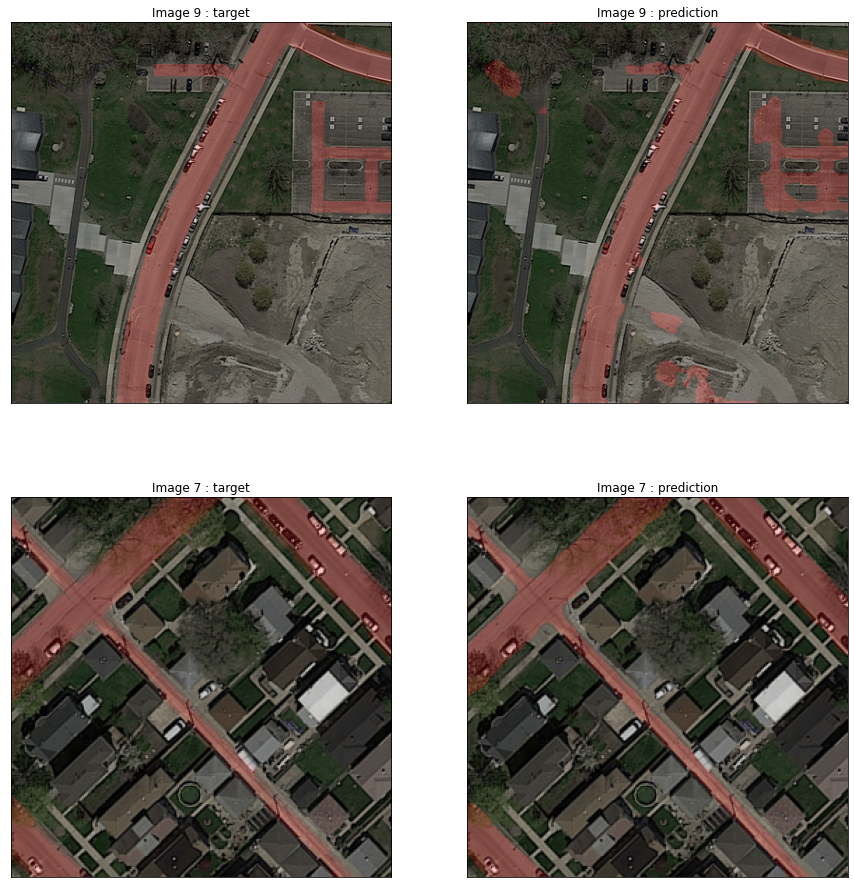

In [23]:
img_to_show = (9, 7)
imshow_overlay_validation(img_to_show)

In [24]:
imgs = []
for img in dataset_test:
  with torch.no_grad():
    output = model.forward(img[None].to(device))
    yhat2 = output.argmax(dim=1).to(torch.float32)[0].cpu().numpy()
  imgs.append(yhat2)
print(len(imgs))
print(imgs[0].shape)

50
(608, 608)


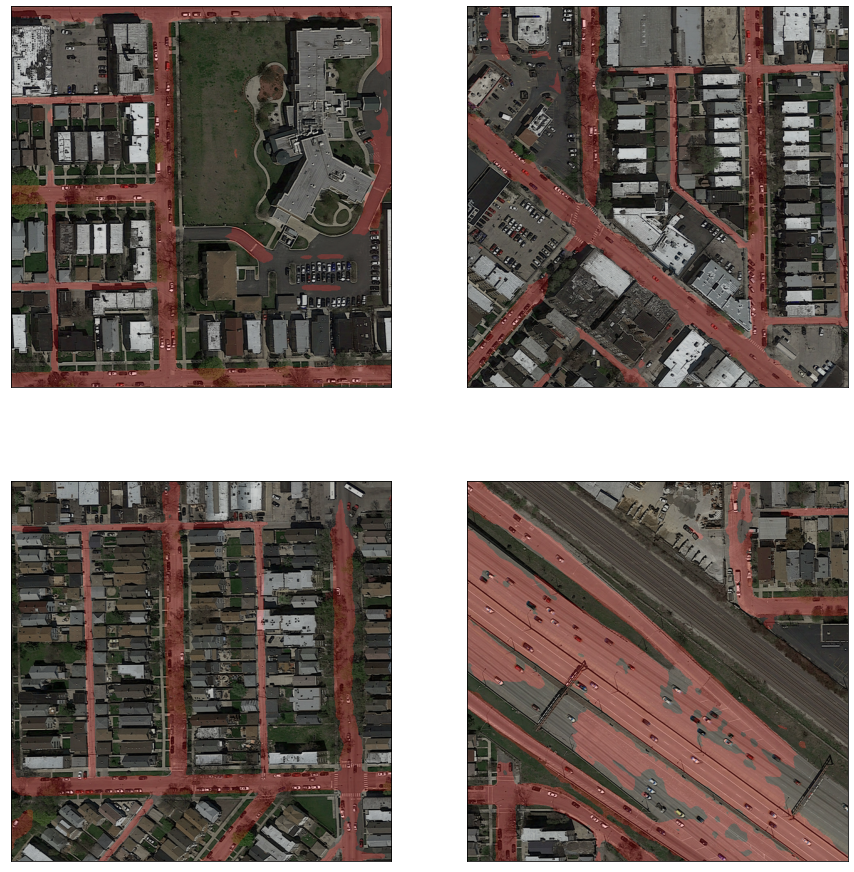

In [25]:
img_to_show = (2, 4, 6, 8)
imshow_overlay_test(img_to_show)

In [ ]:
number_submission = np.load("submissions/number_submission.npy")[0]
print(number_submission)

In [ ]:
submission_filename = f'submissions/submission_{number_submission}_BRAZ_DURAND_NICOLLE.csv'
masks_to_submission(submission_filename, imgs) # actual best : 16 : F1 0.884
number_submission+=1
np.save("submissions/number_submission.npy",np.array([number_submission]))

     _____________________________________________________________________________________________________________________________